In [ ]:
%pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 47.9 MB/s eta 0:00:00


In [ ]:
%pip install Augmentor

In [ ]:
%pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=78fce26806ca2b6214ad0a3224390b59fef34c162837832f31d3c8446a4daeb4
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
!mkdir original_data

In [ ]:
# Import libs

from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import Augmentor
import numpy as np
import umap

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import DBSCAN

from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from keras.models import Model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

import os

ImportError: cannot import name 'DBSCAN' from 'sklearn.decomposition' (/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/__init__.py)

In [ ]:
# Define some of parametrs

img_size = [128, 128]
batch_size = 32

In [ ]:
# There is no good enough data set, so i generate my own
# Start with 50 diffrent molecules

molecules_smiles = [
    'CCBr', 'CCCl', 'CC(C)(C)CC(C)C',
    'CBr', 'CC=CCC(C)C', 'CC(C)=CC(C)C',
    'CCBr', 'CC#CCC(C)C', 'CC(C)CC#CC',
    'CCl', 'CCC(=O)OC', 'CC(=O)N', 'CCC(=O)N(C)C', 'CC(=O)C(C)C', 'CC(Cl)Cl',
    'O=S(=O)(O)O', 'O=[Ti](O)O', 'OS(=O)(=O)O', 'OP(=O)(O)O', 'OP(=O)(O)S', 'O=[Si](O)(O)O',
    'CC(C)(C)O', 'CC(C)(C)OC(C)C', 'CC(C)(C)OCC(C)C',
    'c1ccccc1C(=O)O', 'c1ccccc1N=C=S', 'c1ccc(cc1)C=O', 'c1ccccc1OC(C)C', 'c1ccccc1OCCN', 'c1ccc(cc1)C(C)(C)C',
    'C(=O)O', 'CC(=O)O', 'O=C(O)C=C', 'O=Cl(=O)(=O)O', 'O=[As](O)O', 'I(Cl)Cl',
    'CI', 'CCI', 'CI(=O)=O',
    'CC(=O)CC(C)C', 'CC(Cl)(Cl)Cl', 'C(=O)CC(C)C',
    'C(Br)(Br)Br', 'C(=O)N(C)C', 'CC(=O)OC(C)C',
    'CC(C)N', 'CC(C)NC(C)C', 'CC(C)N(C)C',
    'CC(=O)N(C)C', 'CCC(=O)N(C)C'
]

opts = Draw.MolDrawOptions()
opts.bondLineWidth = 10
opts.fontBold = True
opts.minFontSize = 30
opts.fontScale = 5

for i, smiles in enumerate(molecules_smiles):
    mol = Chem.MolFromSmiles(smiles)

    # Check if the molecule is valid
    if mol is None:
        print(f"Invalid SMILES for molecule {i + 1}: {smiles}")
        continue

    img = Draw.MolToImage(mol, size = (img_size[0], img_size[1]), kekulize=False, wedgeBonds=False, options=opts)

    img_path = f'original_data/molecule_{i + 1}.png'

    img.save(img_path)

In [ ]:
# Save them into images list
# I need this to future model gitting

files = os.listdir('original_data/')

files = [file for file in files if file.lower().endswith('.png')]

images = []

for png_file in files:
    image_path = os.path.join("original_data/", png_file)
    img = Image.open(image_path)
    images.append(img)

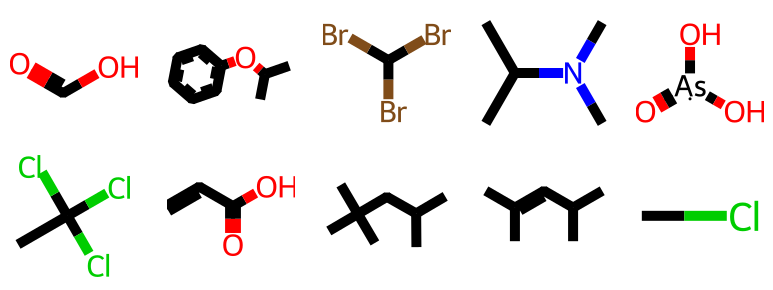

In [ ]:
# Show 10 of them

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (8, 3))

for i in range(10):
    img = images[i]
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# I need much more molecules to train autoencoder
# So i use Augmentor to create new similar images

pipeline = Augmentor.Pipeline('original_data', output_directory = 'augmented_data')

pipeline.rotate(probability = 0.95, max_left_rotation = 10, max_right_rotation = 10)
pipeline.zoom_random(probability = 0.95, percentage_area = 0.9)

pipeline.sample(1050)

Initialised with 50 image(s) found.
Output directory set to original_data/augmented_data.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7BD6705D7FD0>: 100%|██████████| 1050/1050 [00:11<00:00, 92.18 Samples/s] 


In [ ]:
# Grab them into images collection

augmented_dir = 'original_data/augmented_data'

files = [file for file in os.listdir(augmented_dir) if file.lower().endswith('.png')]

for png_file in files:
    image_path = os.path.join(augmented_dir, png_file)
    img = Image.open(image_path)
    images.append(img)

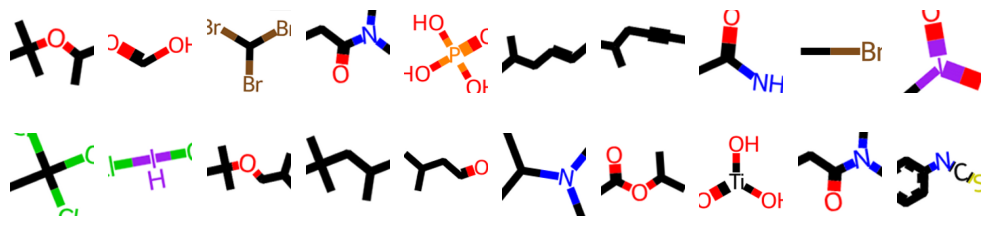

In [ ]:
# Plot 20 augmented images

fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize = (10, 3))

for i in range(500, 520):
    pil_image = images[i]
    ax = axes[(i - 500) // 10, (i - 500) % 10]
    ax.imshow(pil_image)
    ax.axis('off')

plt.tight_layout()
plt.show()

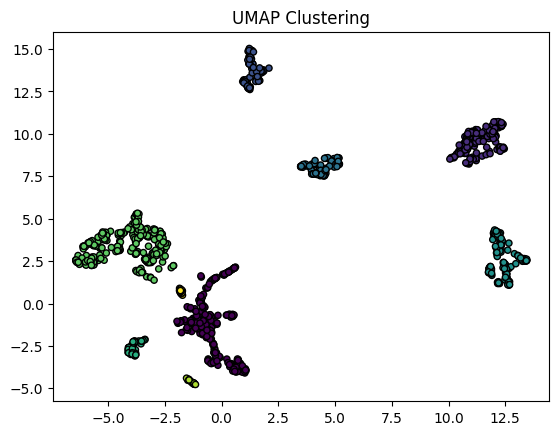

In [ ]:
# Try to distribute into some clusters

image_arrays = [np.array(img) for img in images]

flattened_images = [img.flatten() for img in image_arrays]

umap_model = umap.UMAP(n_components = 2)
umap_result = umap_model.fit_transform(flattened_images)

clustering = DBSCAN(eps = 0.6, min_samples = 5)
clustering.fit(umap_result)

labels = clustering.labels_

plt.scatter(umap_result[:, 0], umap_result[:, 1], c = labels, s = 20, cmap = "viridis", edgecolors = 'black')
plt.title('UMAP Clustering')
plt.show()

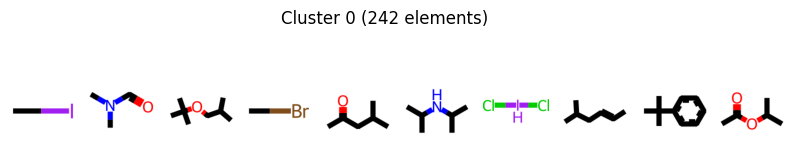

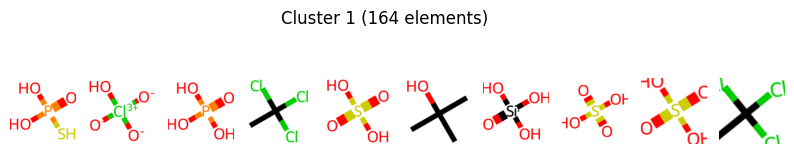

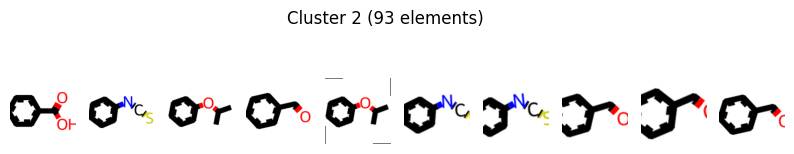

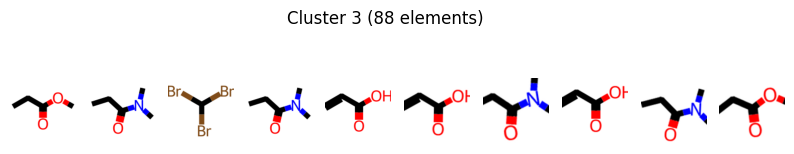

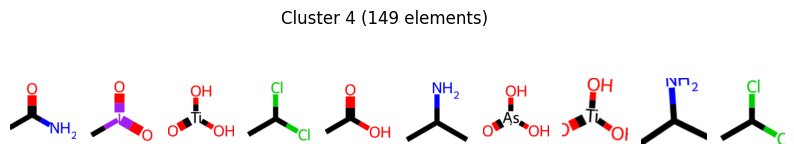

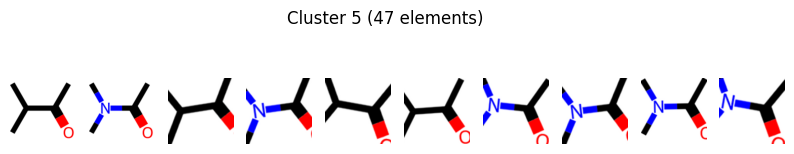

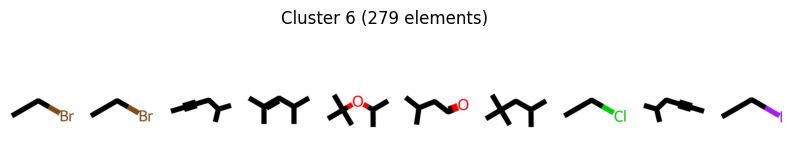

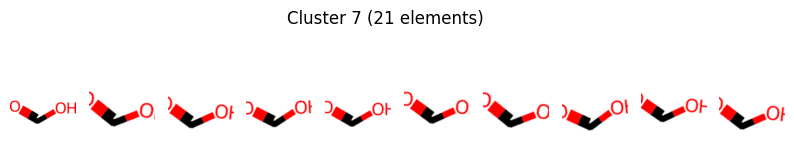

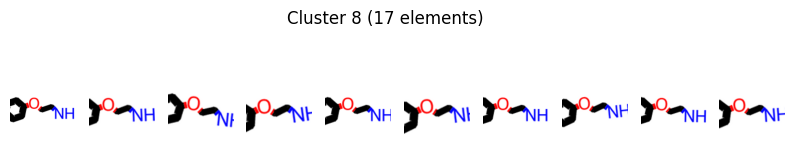

In [ ]:
# Let's see what elements form one cluster

unique_clusters, cluster_counts = np.unique(labels, return_counts = True)

for cluster_index in unique_clusters:
    plt.figure(figsize = (10, 4))

    cluster_mask = labels == cluster_index
    cluster_images = np.array(images)[cluster_mask]

    for i in range(min(10, len(cluster_images))):
        plt.subplot(1, 10, i + 1)
        plt.imshow(cluster_images[i])
        plt.axis('off')

    plt.suptitle(f'Cluster {cluster_index} ({cluster_counts[cluster_index]} elements)', y = 0.75)
    plt.show()


In [ ]:
# !rm -R original_data

In [ ]:
# Now split all images into train & test sets
# To make fitting easer i decid to convert images into gray scale

X_train, X_test = train_test_split(images, train_size = 0.8, random_state = 42)

X_train = [i.convert('L') for i in X_train]
X_train = np.array([np.array(i) for i in X_train])
X_train = X_train / 255.0
X_train = np.reshape(X_train, (len(X_train), img_size[0], img_size[1], 1))

X_test = [i.convert('L') for i in X_test]
X_test = np.array([np.array(i) for i in X_test])
X_test = X_test / 255.0
X_test = np.reshape(X_test, (len(X_test), img_size[0], img_size[1], 1))

In [ ]:
# Define early stopping to avoid overfitting

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [ ]:
# Define functions to display first 10 pridected images & compear them with orivinals
# Also define function that shows fitting process

def show_resualts(autoencoder, X_test):
    n = 10

    imgs = X_test[:n]
    decoded_imgs = autoencoder.predict(X_test[:n], batch_size = n)

    plt.figure(figsize = (n, 2))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].squeeze(), cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax2 = plt.subplot(2, n, i + n + 1)
        plt.imshow(decoded_imgs[i].squeeze(), cmap = 'gray')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

    plt.show()


def show_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# As soon as i find good model i will fit it into RGB images
# So i need to show original and predicted images not into gray scale

def show_RGBresualts(autoencoder, X_test):
    n = 10

    imgs = X_test[:n]
    decoded_imgs = autoencoder.predict(X_test[:n], batch_size = n)

    plt.figure(figsize = (n, 2))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax2 = plt.subplot(2, n, i + n + 1)
        plt.imshow(decoded_imgs[i].squeeze())
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

    plt.show()


In [ ]:
# Model #1
# Try simple fully connected neural network

input_img = Input((img_size[0], img_size[1], 1))
x = Flatten()(input_img)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
encoded = Dense(512, activation = 'relu')(x)

d = Dense(128, activation = 'relu')(encoded)
d = Dense(256, activation = 'relu')(d)
d = Dense(512, activation = 'relu')(d)
d = Dense(img_size[0] * img_size[1], activation = 'sigmoid')(d)
decoded = Reshape((img_size[0], img_size[1], 1))(d)

autoencoder = keras.Model(input_img, decoded, name = "autoencoder")
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
# Fit it

history = autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 13s 368ms/step - loss: 0.1176 - val_loss: 0.0871
Epoch 2/50
28/28 [==============================] - 11s 391ms/step - loss: 0.0881 - val_loss: 0.0877
Epoch 3/50
28/28 [==============================] - 11s 394ms/step - loss: 0.0876 - val_loss: 0.0861
Epoch 4/50
28/28 [==============================] - 12s 420ms/step - loss: 0.0868 - val_loss: 0.0829
Epoch 5/50
28/28 [==============================] - 11s 396ms/step - loss: 0.0821 - val_loss: 0.0777
Epoch 6/50
28/28 [==============================] - 11s 392ms/step - loss: 0.0774 - val_loss: 0.0756
Epoch 7/50
28/28 [==============================] - 18s 643ms/step - loss: 0.0739 - val_loss: 0.0722
Epoch 8/50
28/28 [==============================] - 22s 785ms/step - loss: 0.0701 - val_loss: 0.0677
Epoch 9/50
28/28 [==============================] - 19s 684ms/step - loss: 0.0658 - val_loss: 0.0627
Epoch 10/50
28/28 [==============================] - 13s 438ms/step - loss: 0.0632 - val_lo

1/1 [==============================] - 0s 163ms/step


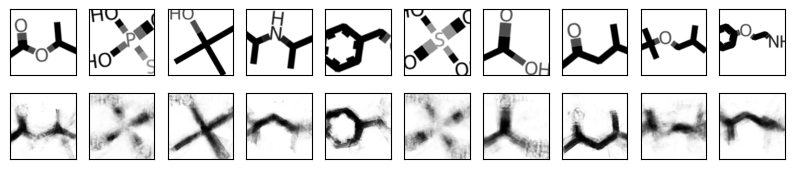

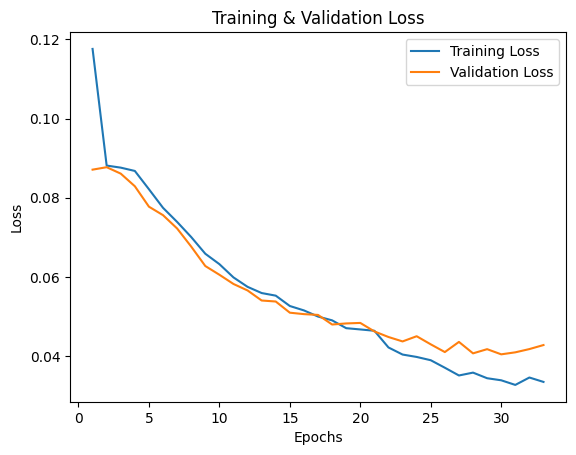

In [ ]:
# Display resualts

show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
# Model #2
# There is no good at all in previous model,
# So try to make it more complicated,
# Just increase number of neurons

input_img = Input((img_size[0], img_size[1], 1))
x = Flatten()(input_img)
x = Dense(2048, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
encoded = Dense(512, activation = 'relu')(x)

d = Dense(1024, activation = 'relu')(encoded)
d = Dense(img_size[0] * img_size[1], activation = 'sigmoid')(d)
decoded = Reshape((img_size[0], img_size[1], 1))(d)

autoencoder = keras.Model(input_img, decoded, name = "autoencoder")
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 33s 1s/step - loss: 0.1067 - val_loss: 0.0866
Epoch 2/50
28/28 [==============================] - 31s 1s/step - loss: 0.0869 - val_loss: 0.0823
Epoch 3/50
28/28 [==============================] - 30s 1s/step - loss: 0.0787 - val_loss: 0.0736
Epoch 4/50
28/28 [==============================] - 30s 1s/step - loss: 0.0701 - val_loss: 0.0641
Epoch 5/50
28/28 [==============================] - 32s 1s/step - loss: 0.0626 - val_loss: 0.0583
Epoch 6/50
28/28 [==============================] - 30s 1s/step - loss: 0.0578 - val_loss: 0.0537
Epoch 7/50
28/28 [==============================] - 30s 1s/step - loss: 0.0546 - val_loss: 0.0506
Epoch 8/50
28/28 [==============================] - 31s 1s/step - loss: 0.0500 - val_loss: 0.0484
Epoch 9/50
28/28 [==============================] - 30s 1s/step - loss: 0.0464 - val_loss: 0.0466
Epoch 10/50
28/28 [==============================] - 30s 1s/step - loss: 0.0445 - val_loss: 0.0457
Epoch 11/50
28/28 [

1/1 [==============================] - 0s 141ms/step


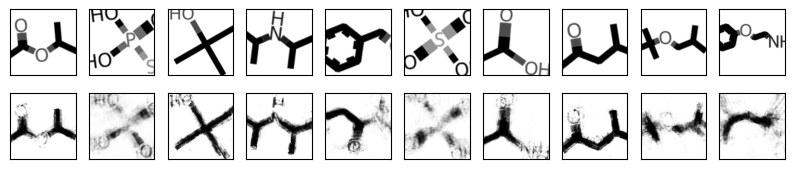

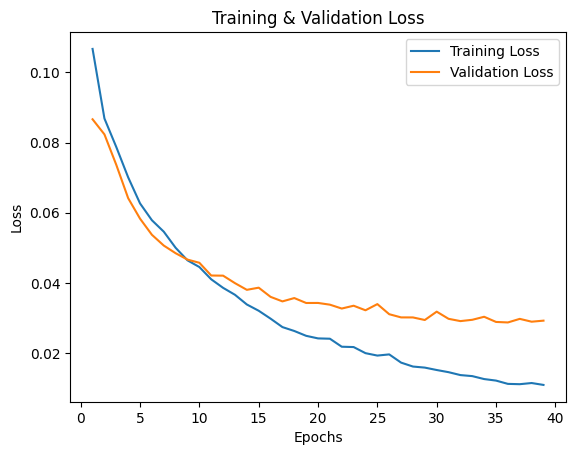

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
# Model #3
# Based on metrics it shows better resualts, but still not good enough
# Try to simplify model

input_img = Input((img_size[0], img_size[1], 1))
x = Flatten()(input_img)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
encoded = Dense(64, activation = 'relu')(x)

d = Dense(128, activation = 'relu')(encoded)
d = Dense(256, activation = 'relu')(d)
d = Dense(img_size[0] * img_size[1], activation = 'sigmoid')(d)
decoded = Reshape((img_size[0], img_size[1], 1))(d)

autoencoder = keras.Model(input_img, decoded, name = "autoencoder")
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 200,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/200
28/28 [==============================] - 5s 129ms/step - loss: 0.1090 - val_loss: 0.0866
Epoch 2/200
28/28 [==============================] - 4s 134ms/step - loss: 0.0863 - val_loss: 0.0812
Epoch 3/200
28/28 [==============================] - 4s 149ms/step - loss: 0.0779 - val_loss: 0.0717
Epoch 4/200
28/28 [==============================] - 3s 122ms/step - loss: 0.0707 - val_loss: 0.0654
Epoch 5/200
28/28 [==============================] - 4s 136ms/step - loss: 0.0630 - val_loss: 0.0584
Epoch 6/200
28/28 [==============================] - 5s 162ms/step - loss: 0.0583 - val_loss: 0.0549
Epoch 7/200
28/28 [==============================] - 4s 127ms/step - loss: 0.0556 - val_loss: 0.0518
Epoch 8/200
28/28 [==============================] - 4s 130ms/step - loss: 0.0519 - val_loss: 0.0496
Epoch 9/200
28/28 [==============================] - 5s 163ms/step - loss: 0.0494 - val_loss: 0.0480
Epoch 10/200
28/28 [==============================] - 3s 123ms/step - loss: 0.0460 - val_lo

1/1 [==============================] - 0s 110ms/step


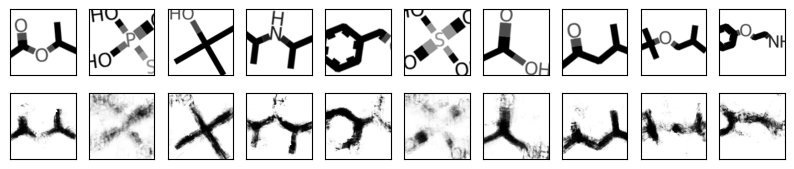

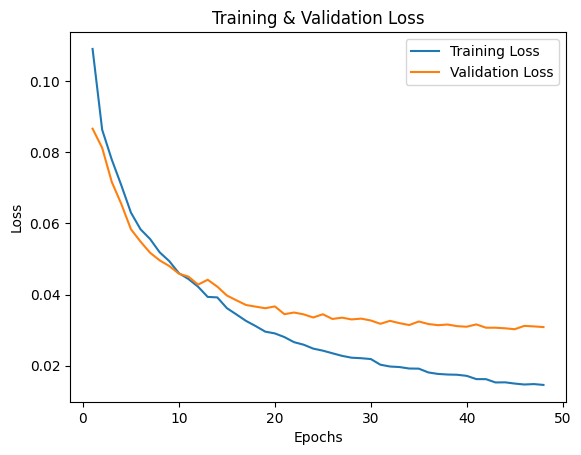

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
# Model #4
# Simplify mothod shows no good at all
# So i decied to get rid of fully connected neural network and apply
# сonvolutional neural network, so it basicly shows better resualts
# in image preproceccing

input_img = Input(shape = (img_size[0], img_size[1], 1))

x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 25,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/25
28/28 [==============================] - 35s 1s/step - loss: 0.1225 - val_loss: 0.0509
Epoch 2/25
28/28 [==============================] - 33s 1s/step - loss: 0.0300 - val_loss: 0.0194
Epoch 3/25
28/28 [==============================] - 36s 1s/step - loss: 0.0150 - val_loss: 0.0127
Epoch 4/25
28/28 [==============================] - 39s 1s/step - loss: 0.0110 - val_loss: 0.0099
Epoch 5/25
28/28 [==============================] - 32s 1s/step - loss: 0.0091 - val_loss: 0.0094
Epoch 6/25
28/28 [==============================] - 34s 1s/step - loss: 0.0081 - val_loss: 0.0076
Epoch 7/25
28/28 [==============================] - 32s 1s/step - loss: 0.0071 - val_loss: 0.0071
Epoch 8/25
28/28 [==============================] - 33s 1s/step - loss: 0.0067 - val_loss: 0.0067
Epoch 9/25
28/28 [==============================] - 32s 1s/step - loss: 0.0064 - val_loss: 0.0062
Epoch 10/25
28/28 [==============================] - 34s 1s/step - loss: 0.0059 - val_loss: 0.0061
Epoch 11/25
28/28 [

1/1 [==============================] - 1s 515ms/step


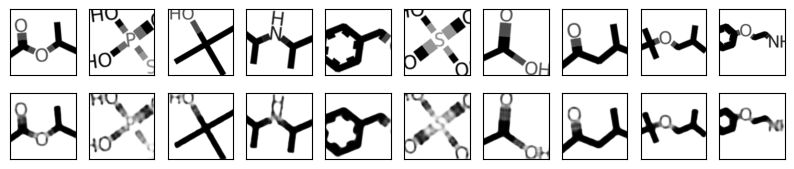

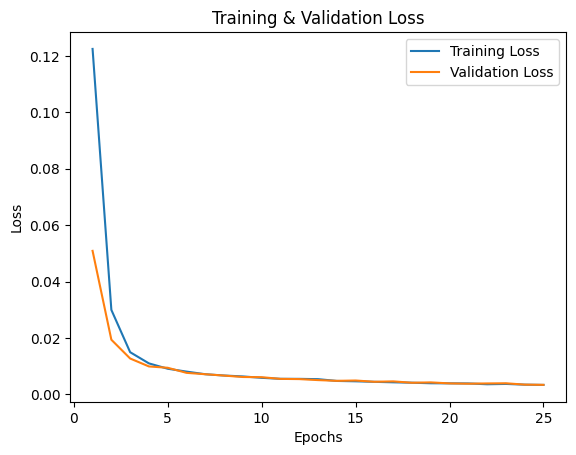

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
# Model #5
# It's became much better then fully connected neural network
# Try to build more complicated сonvolutional neural network
# Increas number of kernels and make first layer kernel size 5x5 instand of 3x3

input_img = Input(shape = (img_size[0], img_size[1], 1))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 25,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/25
28/28 [==============================] - 48s 2s/step - loss: 0.1092 - val_loss: 0.0532
Epoch 2/25
28/28 [==============================] - 47s 2s/step - loss: 0.0303 - val_loss: 0.0197
Epoch 3/25
28/28 [==============================] - 46s 2s/step - loss: 0.0167 - val_loss: 0.0141
Epoch 4/25
28/28 [==============================] - 46s 2s/step - loss: 0.0127 - val_loss: 0.0116
Epoch 5/25
28/28 [==============================] - 45s 2s/step - loss: 0.0099 - val_loss: 0.0092
Epoch 6/25
28/28 [==============================] - 46s 2s/step - loss: 0.0081 - val_loss: 0.0085
Epoch 7/25
28/28 [==============================] - 45s 2s/step - loss: 0.0071 - val_loss: 0.0068
Epoch 8/25
28/28 [==============================] - 47s 2s/step - loss: 0.0065 - val_loss: 0.0062
Epoch 9/25
28/28 [==============================] - 45s 2s/step - loss: 0.0058 - val_loss: 0.0057
Epoch 10/25
28/28 [==============================] - 46s 2s/step - loss: 0.0054 - val_loss: 0.0054
Epoch 11/25
28/28 [

1/1 [==============================] - 0s 204ms/step


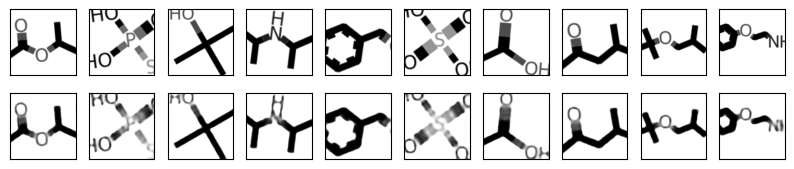

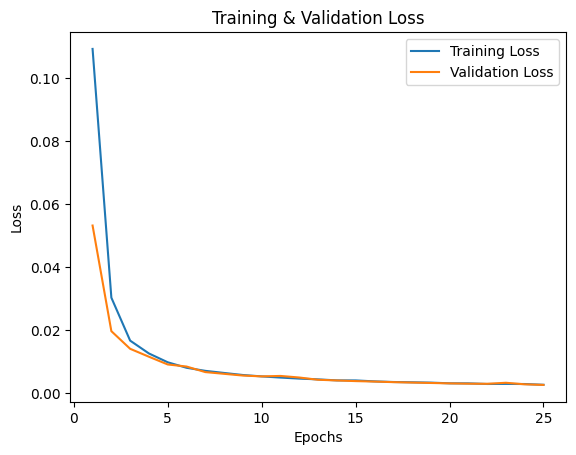

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
# Model #6
# So it's became better, than probably i can reach better resualts if
# Increas not only first layer kernel size
# Try to make second layer kernel 5x5 too

input_img = Input(shape = (img_size[0], img_size[1], 1))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (5, 5), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 25,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/25
28/28 [==============================] - 59s 2s/step - loss: 0.1130 - val_loss: 0.0549
Epoch 2/25
28/28 [==============================] - 77s 3s/step - loss: 0.0289 - val_loss: 0.0171
Epoch 3/25
28/28 [==============================] - 57s 2s/step - loss: 0.0151 - val_loss: 0.0131
Epoch 4/25
28/28 [==============================] - 56s 2s/step - loss: 0.0111 - val_loss: 0.0105
Epoch 5/25
28/28 [==============================] - 58s 2s/step - loss: 0.0090 - val_loss: 0.0085
Epoch 6/25
28/28 [==============================] - 55s 2s/step - loss: 0.0077 - val_loss: 0.0075
Epoch 7/25
28/28 [==============================] - 56s 2s/step - loss: 0.0070 - val_loss: 0.0066
Epoch 8/25
28/28 [==============================] - 58s 2s/step - loss: 0.0064 - val_loss: 0.0061
Epoch 9/25
28/28 [==============================] - 55s 2s/step - loss: 0.0057 - val_loss: 0.0055
Epoch 10/25
28/28 [==============================] - 55s 2s/step - loss: 0.0052 - val_loss: 0.0052
Epoch 11/25
28/28 [

1/1 [==============================] - 0s 249ms/step


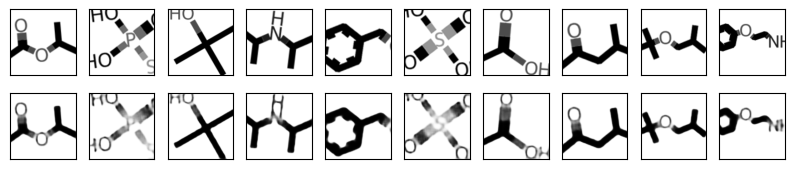

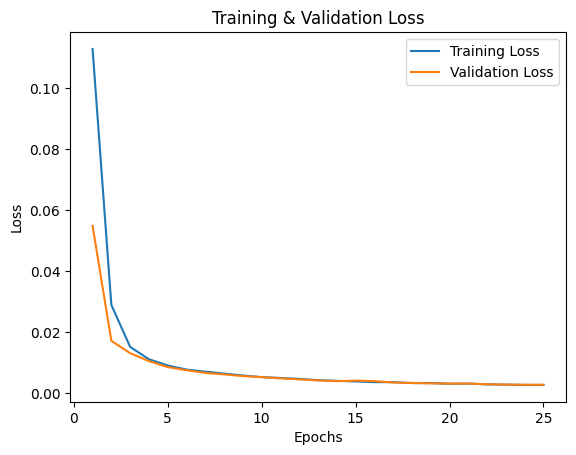

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
# Model #7
# So the model #6 and model #5 shows same metrics
# Now i give 50 epochs instand of 25 to modele #5
# I choose mode #5 because it fit faster than model #6

input_img = Input(shape = (img_size[0], img_size[1], 1))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 55s 2s/step - loss: 0.1212 - val_loss: 0.0656
Epoch 2/50
28/28 [==============================] - 46s 2s/step - loss: 0.0379 - val_loss: 0.0187
Epoch 3/50
28/28 [==============================] - 48s 2s/step - loss: 0.0158 - val_loss: 0.0127
Epoch 4/50
28/28 [==============================] - 49s 2s/step - loss: 0.0109 - val_loss: 0.0108
Epoch 5/50
28/28 [==============================] - 48s 2s/step - loss: 0.0092 - val_loss: 0.0091
Epoch 6/50
28/28 [==============================] - 46s 2s/step - loss: 0.0079 - val_loss: 0.0076
Epoch 7/50
28/28 [==============================] - 44s 2s/step - loss: 0.0070 - val_loss: 0.0068
Epoch 8/50
28/28 [==============================] - 44s 2s/step - loss: 0.0065 - val_loss: 0.0062
Epoch 9/50
28/28 [==============================] - 45s 2s/step - loss: 0.0058 - val_loss: 0.0061
Epoch 10/50
28/28 [==============================] - 43s 2s/step - loss: 0.0054 - val_loss: 0.0055
Epoch 11/50
28/28 [

1/1 [==============================] - 0s 249ms/step


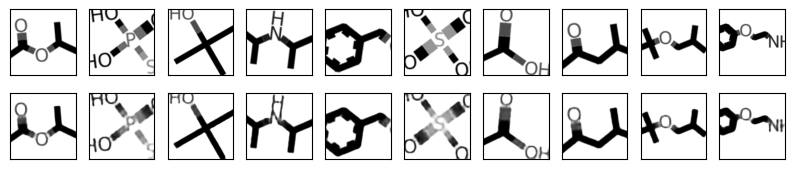

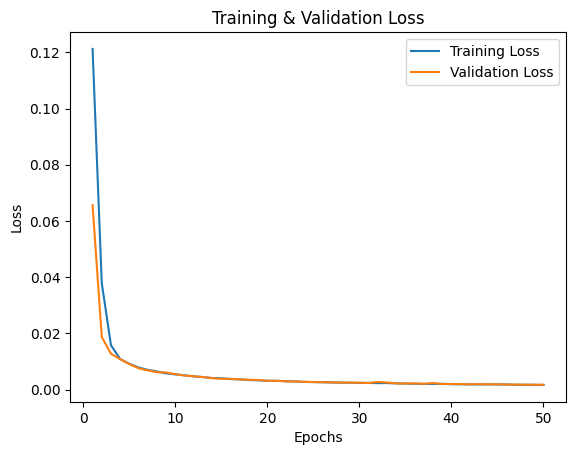

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
# Now i need colorized images to eork with
# As soon as i use random_state = 42 i can split train and tests sets
# just like in gray scale sets

X_train, X_test = train_test_split(images, train_size = 0.8, random_state = 42)

X_train = np.array([np.array(i) for i in X_train])
X_train = X_train / 255.0
X_train = np.reshape(X_train, (len(X_train), img_size[0], img_size[1], 3))

X_test = np.array([np.array(i) for i in X_test])
X_test = X_test / 255.0
X_test = np.reshape(X_test, (len(X_test), img_size[0], img_size[1], 3))

In [ ]:
# Model #8
# Now try preprocess colorized images with the best one model (model #7),
# But increas number of color maps

input_img = Input(shape = (img_size[0], img_size[1], 3))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 51s 2s/step - loss: 0.1239 - val_loss: 0.0965
Epoch 2/50
28/28 [==============================] - 50s 2s/step - loss: 0.0775 - val_loss: 0.0497
Epoch 3/50
28/28 [==============================] - 48s 2s/step - loss: 0.0374 - val_loss: 0.0265
Epoch 4/50
28/28 [==============================] - 49s 2s/step - loss: 0.0211 - val_loss: 0.0186
Epoch 5/50
28/28 [==============================] - 52s 2s/step - loss: 0.0162 - val_loss: 0.0142
Epoch 6/50
28/28 [==============================] - 49s 2s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 7/50
28/28 [==============================] - 52s 2s/step - loss: 0.0111 - val_loss: 0.0102
Epoch 8/50
28/28 [==============================] - 56s 2s/step - loss: 0.0093 - val_loss: 0.0088
Epoch 9/50
28/28 [==============================] - 73s 3s/step - loss: 0.0086 - val_loss: 0.0084
Epoch 10/50
28/28 [==============================] - 50s 2s/step - loss: 0.0077 - val_loss: 0.0072
Epoch 11/50
28/28 [

1/1 [==============================] - 0s 245ms/step


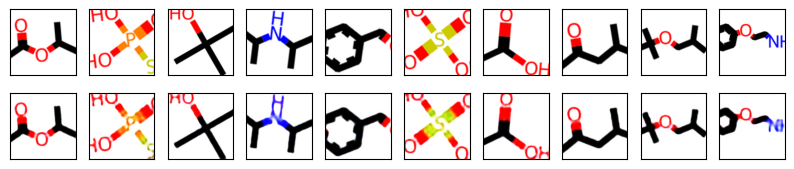

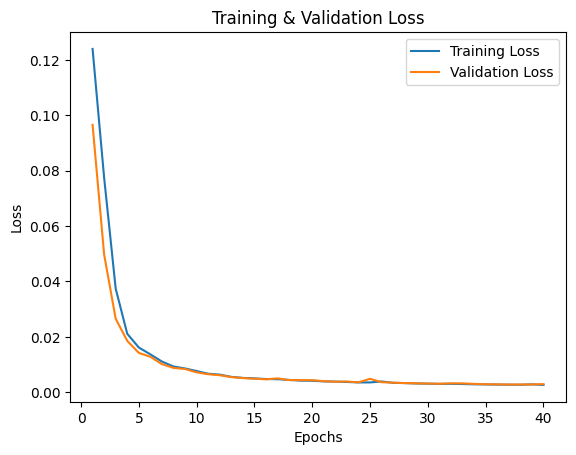

In [ ]:
show_RGBresualts(autoencoder, X_test)
show_history(history)

In [ ]:
# Model #9
# Now try to apply BatchNormalization to rich better generalizing abilities of the model

input_img = Input(shape = (img_size[0], img_size[1], 3))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded_ = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded_)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
decoded_ = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder_ = keras.Model(input_img, decoded_, name = 'autoencoder')
autoencoder_.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder_.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 68s 2s/step - loss: 0.1137 - val_loss: 0.1231
Epoch 2/50
28/28 [==============================] - 55s 2s/step - loss: 0.0374 - val_loss: 0.1117
Epoch 3/50
28/28 [==============================] - 56s 2s/step - loss: 0.0188 - val_loss: 0.1116
Epoch 4/50
28/28 [==============================] - 57s 2s/step - loss: 0.0129 - val_loss: 0.0867
Epoch 5/50
28/28 [==============================] - 57s 2s/step - loss: 0.0101 - val_loss: 0.0620
Epoch 6/50
28/28 [==============================] - 56s 2s/step - loss: 0.0089 - val_loss: 0.0522
Epoch 7/50
28/28 [==============================] - 68s 2s/step - loss: 0.0076 - val_loss: 0.0456
Epoch 8/50
28/28 [==============================] - 57s 2s/step - loss: 0.0067 - val_loss: 0.0377
Epoch 9/50
28/28 [==============================] - 55s 2s/step - loss: 0.0061 - val_loss: 0.0328
Epoch 10/50
28/28 [==============================] - 55s 2s/step - loss: 0.0061 - val_loss: 0.0273
Epoch 11/50
28/28 [

1/1 [==============================] - 1s 534ms/step


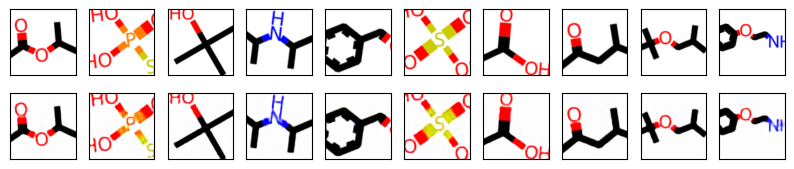

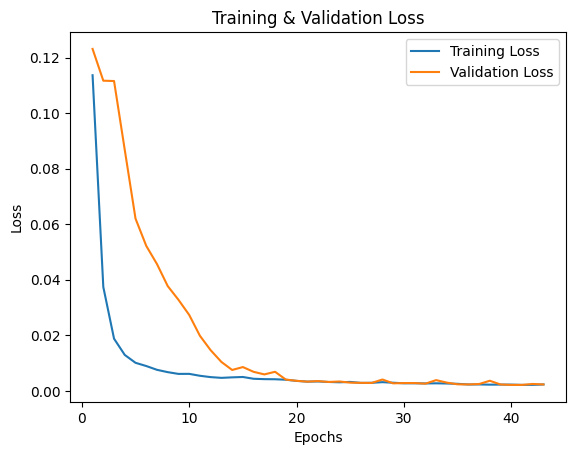

In [ ]:
show_RGBresualts(autoencoder_, X_test)
show_history(history)

1/1 [==============================] - 1s 1s/step


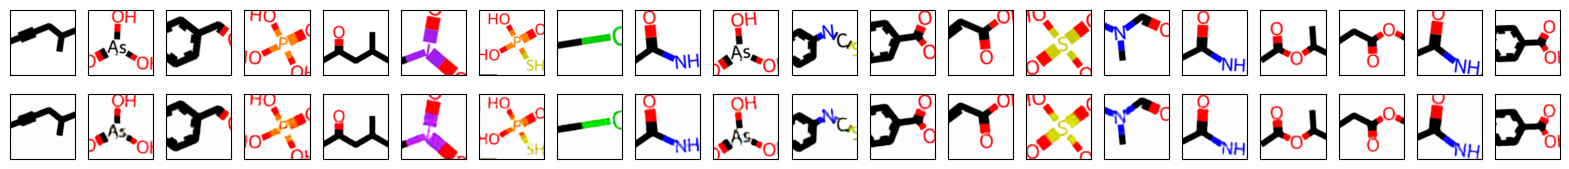

In [ ]:
# See than even metrics became better
# Show 20 more images

n = 20

imgs = X_test[10 : 30]
decoded_imgs = autoencoder_.predict(X_test[10 : 30], batch_size = n)

plt.figure(figsize = (n, 2))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i].squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].squeeze())
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()

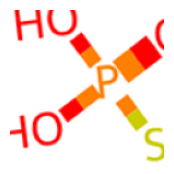

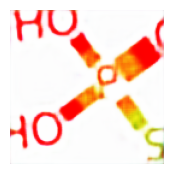

1/1 [==============================] - 1s 572ms/step


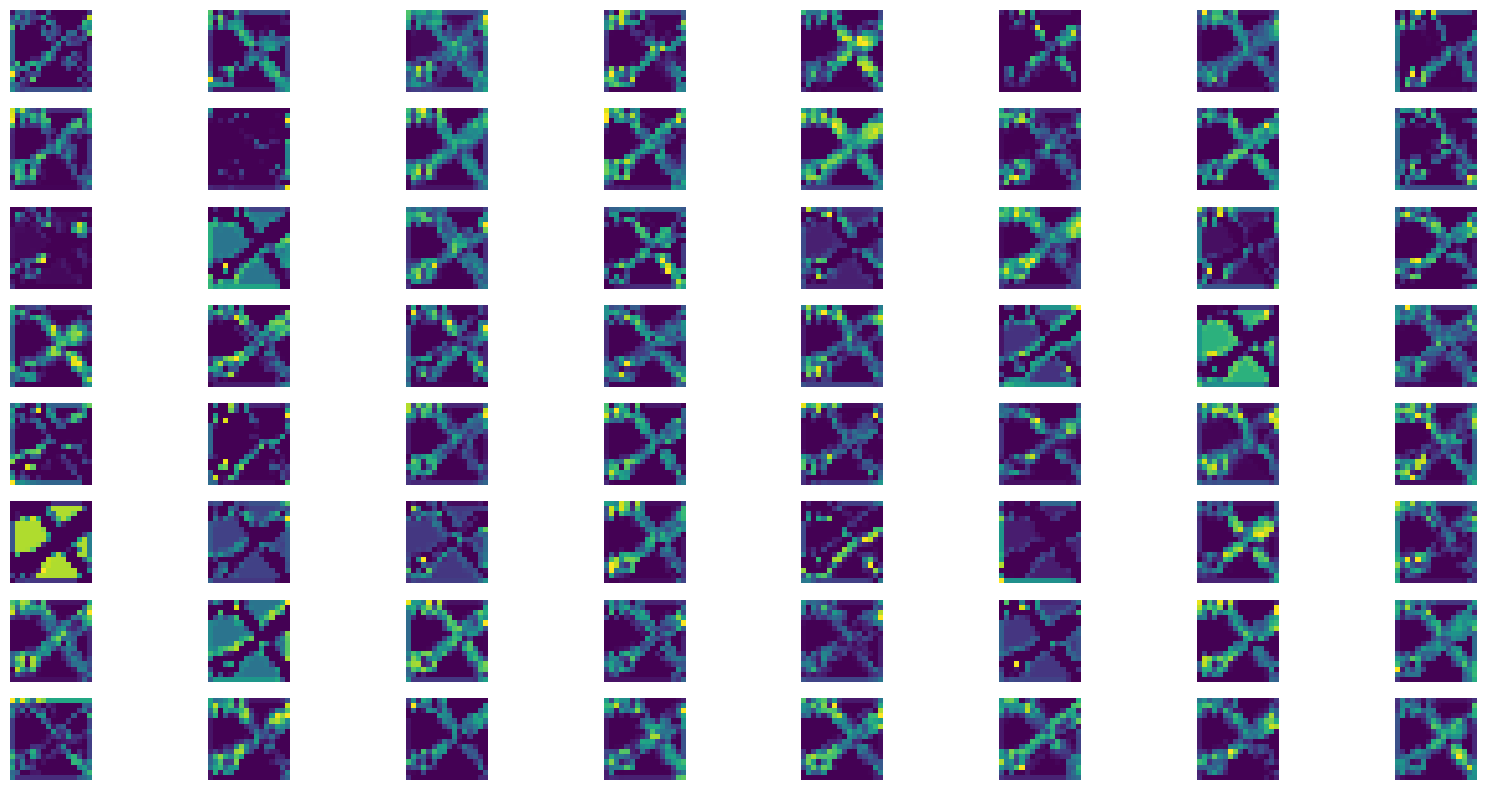

In [ ]:
# Now show how encoder works
# Display original image, restored image and all kernels

encoder_model = Model(inputs = input_img, outputs = encoded_)

to_show = 1

image = X_test[to_show]

plt.figure(figsize = (2, 2))
plt.imshow(image)
plt.axis('off')
plt.show()

predicted_image = autoencoder_(X_test[:20])
plt.figure(figsize = (2, 2))
plt.imshow(predicted_image[to_show], cmap = 'viridis')
plt.axis('off')
plt.show()

encoded_images = encoder_model.predict(X_test[:20])

num_channels = encoded_images.shape[3]
num_rows = 8
num_columns = num_channels // num_rows

plt.figure(figsize = (20, 10))

for i in range(num_channels):
    ax = plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(encoded_images[to_show, :, :, i], cmap = 'viridis')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# See that we have 64 kernels with shape 16 x 16 pixels and original image has
# 128x128 pixels, so i squeeze image size bt 1 time, no squeeze at all

In [ ]:
# Model 10
# Try to reduce number of encoder kernels, but it obviously that we have
# worse resualt, to compensate it try to increase number of other layer kernels

input_img = Input(shape = (img_size[0], img_size[1], 3))

x = Conv2D(64, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded_ = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded_)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
decoded_ = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder_ = keras.Model(input_img, decoded_, name = 'autoencoder')
autoencoder_.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder_.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 105s 4s/step - loss: 0.1156 - val_loss: 0.1169
Epoch 2/50
28/28 [==============================] - 97s 3s/step - loss: 0.0399 - val_loss: 0.1110
Epoch 3/50
28/28 [==============================] - 98s 3s/step - loss: 0.0202 - val_loss: 0.0984
Epoch 4/50
28/28 [==============================] - 97s 3s/step - loss: 0.0143 - val_loss: 0.0717
Epoch 5/50
28/28 [==============================] - 99s 4s/step - loss: 0.0113 - val_loss: 0.0531
Epoch 6/50
28/28 [==============================] - 102s 4s/step - loss: 0.0097 - val_loss: 0.0418
Epoch 7/50
28/28 [==============================] - 97s 3s/step - loss: 0.0086 - val_loss: 0.0353
Epoch 8/50
28/28 [==============================] - 98s 3s/step - loss: 0.0075 - val_loss: 0.0304
Epoch 9/50
28/28 [==============================] - 104s 4s/step - loss: 0.0069 - val_loss: 0.0249
Epoch 10/50
28/28 [==============================] - 96s 3s/step - loss: 0.0064 - val_loss: 0.0229
Epoch 11/50
28/2

1/1 [==============================] - 0s 425ms/step


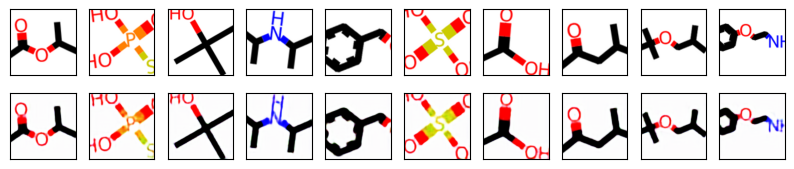

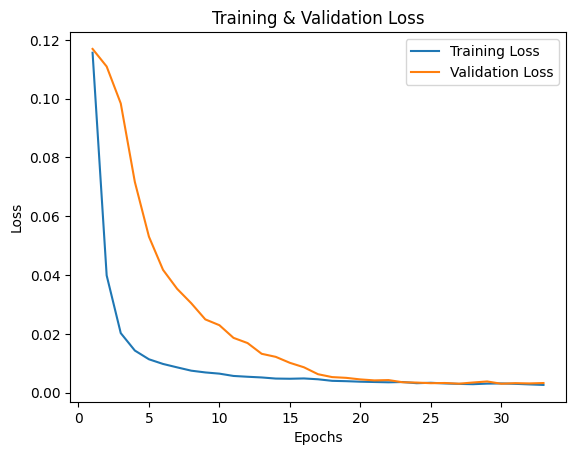

In [ ]:
show_RGBresualts(autoencoder_, X_test)
show_history(history)

1/1 [==============================] - 5s 5s/step


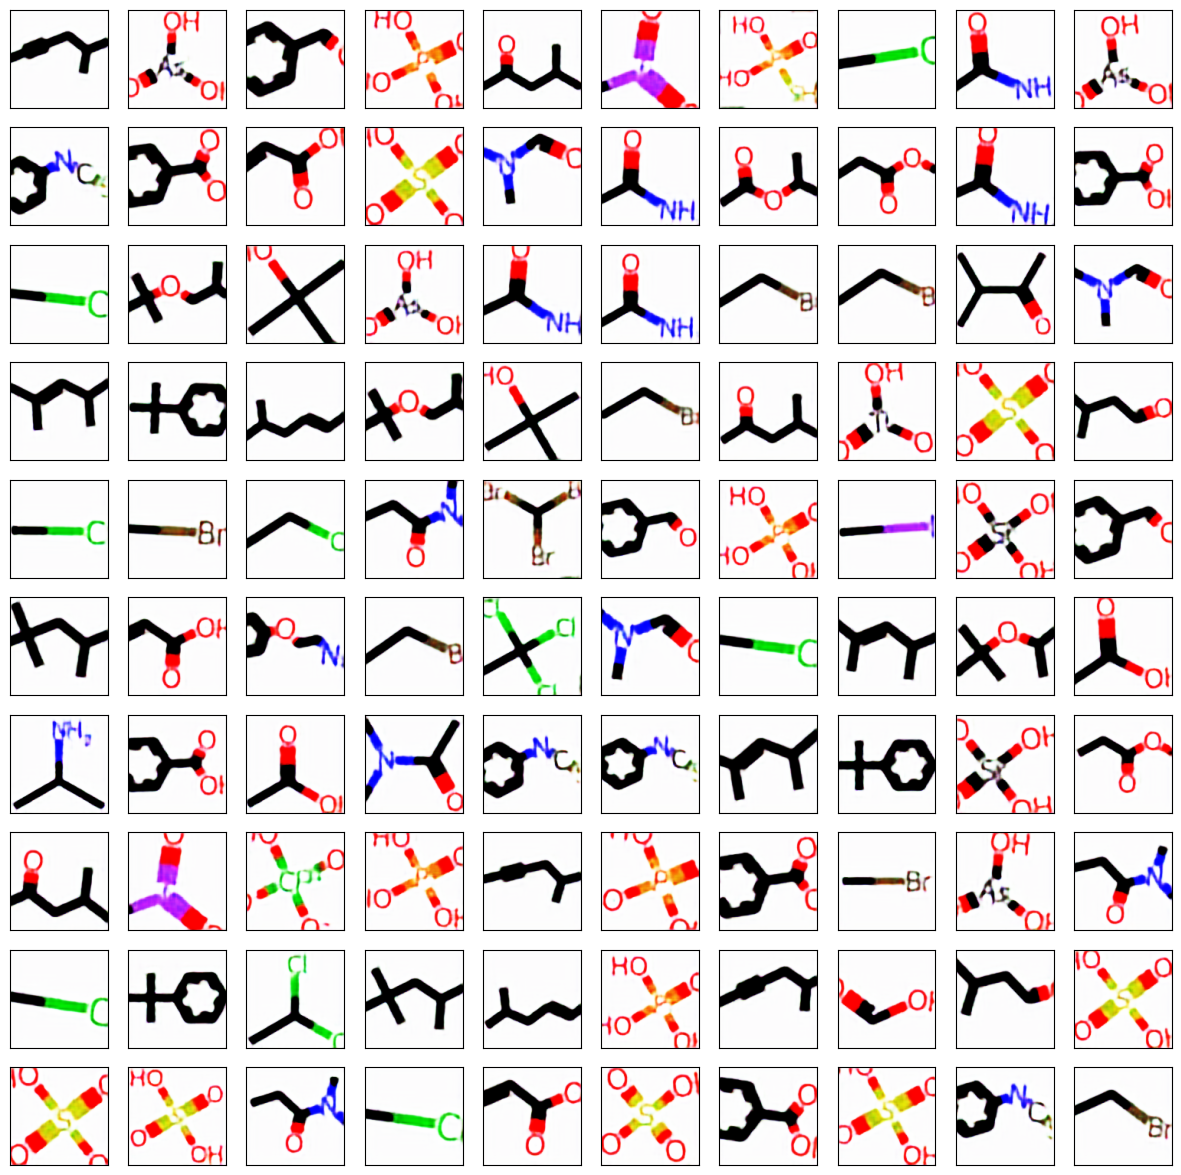

In [ ]:
# It's seems good
# Now display 100 more decoded images

n = 100

imgs = X_test[10 : 110]
decoded_imgs = autoencoder_.predict(X_test[10 : 110], batch_size = n)

plt.figure(figsize = (15, 15))
for i in range(n):
    ax2 = plt.subplot(10, 10, i + 1)
    plt.imshow(decoded_imgs[i].squeeze())
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()

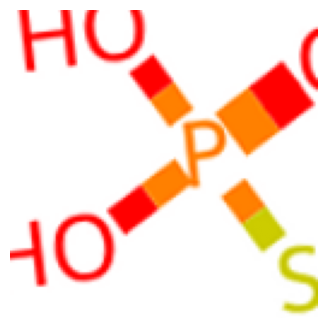

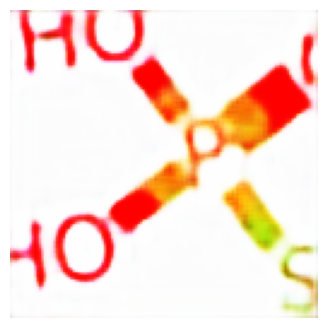

1/1 [==============================] - 1s 956ms/step


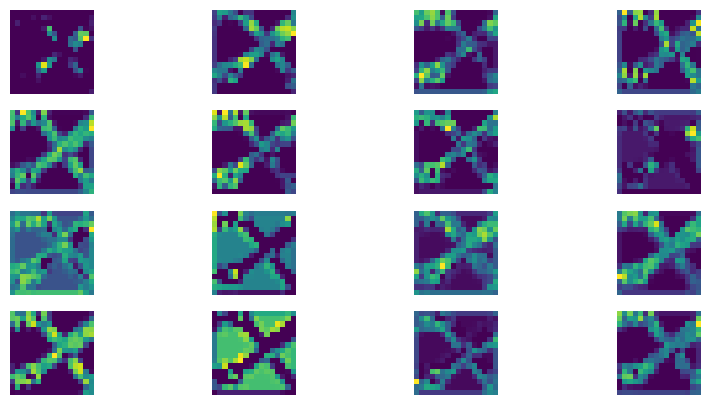

(16, 16, 16)


In [ ]:
# Now i have 16 keranls with 16x16 pixels
# Image size now reduse by 4 times
# Display all kernels

encoder_model = Model(inputs = input_img, outputs = encoded_)

to_show = 1

image = X_test[to_show]

plt.figure(figsize = (4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

predicted_image = autoencoder_(X_test[:20])
plt.figure(figsize = (4, 4))
plt.imshow(predicted_image[to_show], cmap = 'viridis')
plt.axis('off')
plt.show()

encoded_images = encoder_model.predict(X_test[:20])

num_channels = encoded_images.shape[3]
num_rows = 4
num_columns = num_channels // num_rows

plt.figure(figsize = (10, 5))

for i in range(num_channels):
    ax = plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(encoded_images[to_show, :, :, i], cmap = 'viridis')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

print(encoded_images[1].shape)

(-0.5, 127.5, 127.5, -0.5)

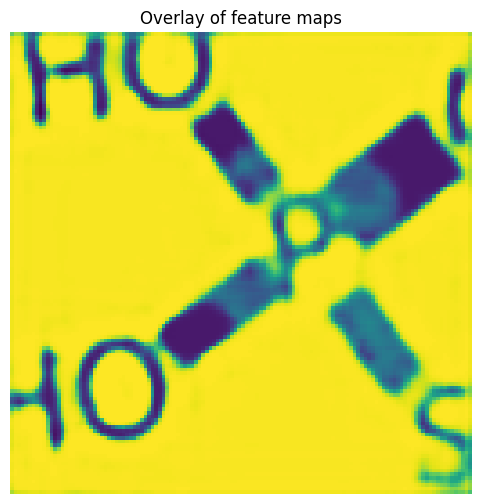

In [ ]:
# Build hit map of all kerals and show it

overlay = np.sum(predicted_image[to_show], axis = 2)
plt.figure(figsize = (6, 6))
plt.imshow(overlay, cmap = 'viridis')
plt.title("Overlay of feature maps")
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

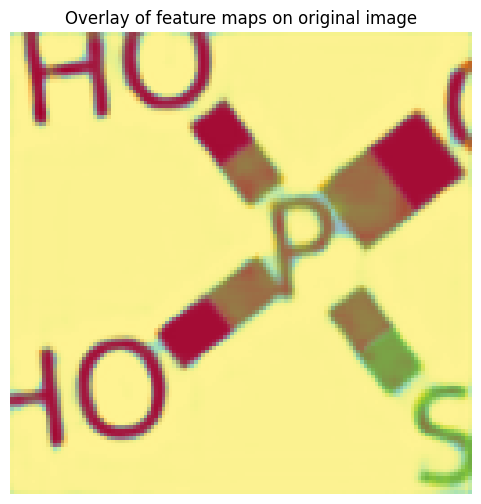

In [ ]:
# Overlay this hit map on base images to show, where model makes mistakes

plt.figure(figsize = (6, 6))
plt.imshow(image, cmap = 'gray')
plt.imshow(overlay, cmap = 'viridis', alpha = 0.5)
plt.title("Overlay of feature maps on original image")
plt.axis('off')

In [ ]:
!zip -r original_data.zip original_data

In [ ]:
from google.colab import files
files.download("original_data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip original_data.zip

Archive:  original_data.zip
   creating: original_data/
   creating: original_data/augmented_data/
  inflating: original_data/augmented_data/original_data_original_molecule_1.png_06b66672-8266-4a50-ab6e-9de4a60bf98c.png  
  inflating: original_data/augmented_data/original_data_original_molecule_1.png_10881c19-da52-4fae-acd5-7baa39d78af2.png  
  inflating: original_data/augmented_data/original_data_original_molecule_1.png_18b25408-5619-44fe-9407-41c39df0d980.png  
  inflating: original_data/augmented_data/original_data_original_molecule_1.png_1ad60e36-e4c1-4af9-be5a-4db2ce4abdeb.png  
  inflating: original_data/augmented_data/original_data_original_molecule_1.png_26701d26-25b4-4331-a7ef-96ff6c4674d6.png  
  inflating: original_data/augmented_data/original_data_original_molecule_1.png_2838d957-14f5-4382-ad1c-683899656a13.png  
  inflating: original_data/augmented_data/original_data_original_molecule_1.png_317bf44a-1c7a-441b-9f4e-6132ea2101e2.png  
  inflating: original_data/augmented_dat

In [ ]:
from google.colab import files
uploader = files.upload()

Saving original_data.zip to original_data.zip


In [ ]:
# Model #11
# Try this model, but try to reduce number of hidden layer kernels by 8

input_img = Input(shape = (img_size[0], img_size[1], 3))

x = Conv2D(64, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded_ = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded_)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
decoded_ = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder_ = keras.Model(input_img, decoded_, name = 'autoencoder')
autoencoder_.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder_.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 97s 3s/step - loss: 0.0957 - val_loss: 0.1245
Epoch 2/50
28/28 [==============================] - 89s 3s/step - loss: 0.0284 - val_loss: 0.1073
Epoch 3/50
28/28 [==============================] - 111s 4s/step - loss: 0.0169 - val_loss: 0.1112
Epoch 4/50
28/28 [==============================] - 122s 4s/step - loss: 0.0133 - val_loss: 0.1097
Epoch 5/50
28/28 [==============================] - 130s 5s/step - loss: 0.0113 - val_loss: 0.0930
Epoch 6/50
28/28 [==============================] - 135s 5s/step - loss: 0.0102 - val_loss: 0.0673
Epoch 7/50
28/28 [==============================] - 125s 4s/step - loss: 0.0092 - val_loss: 0.0518
Epoch 8/50
28/28 [==============================] - 126s 5s/step - loss: 0.0085 - val_loss: 0.0462
Epoch 9/50
28/28 [==============================] - 118s 4s/step - loss: 0.0078 - val_loss: 0.0338
Epoch 10/50
28/28 [==============================] - 93s 3s/step - loss: 0.0073 - val_loss: 0.0271
Epoch 11/50


1/1 [==============================] - 1s 560ms/step


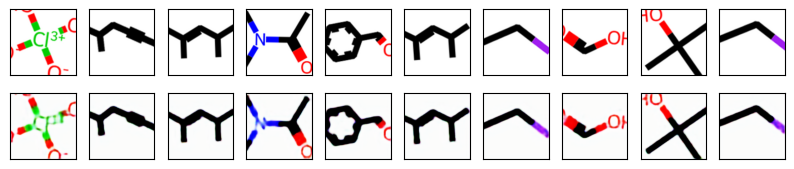

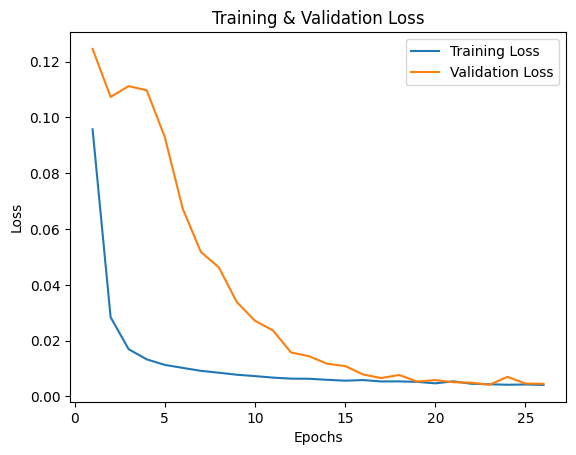

In [ ]:
show_RGBresualts(autoencoder_, X_test)
show_history(history)

1/1 [==============================] - 3s 3s/step


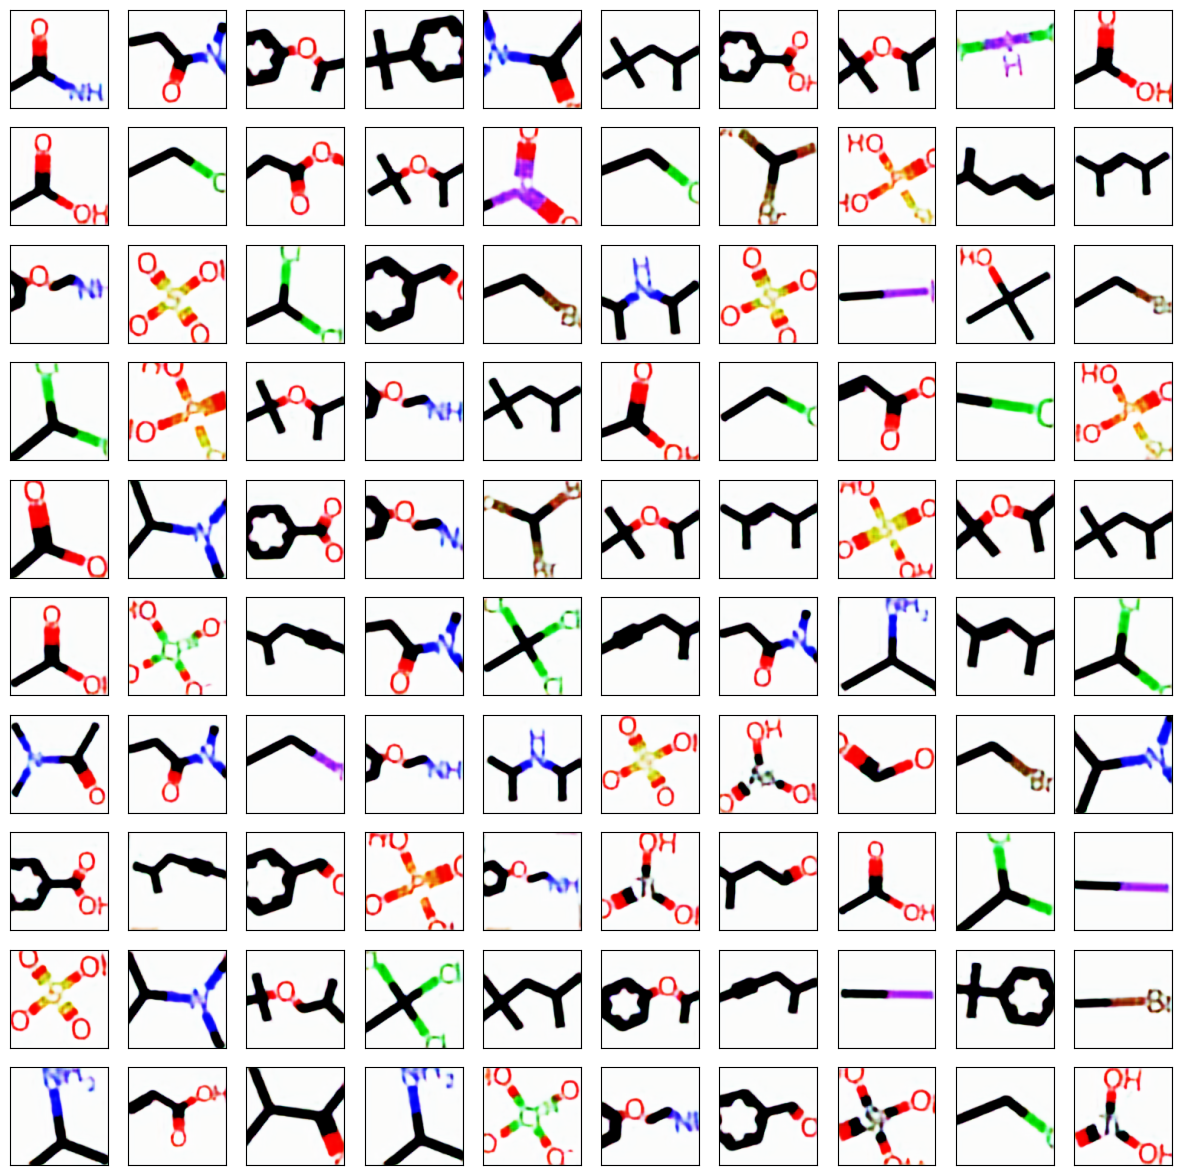

In [ ]:
# See that we have worse metrics,
# But now images size resuce by 8 times
# Show 100 more decoded images

n = 100

imgs = X_test[10 : 110]
decoded_imgs = autoencoder_.predict(X_test[10 : 110], batch_size = n)

plt.figure(figsize = (15, 15))
for i in range(n):
    ax2 = plt.subplot(10, 10, i + 1)
    plt.imshow(decoded_imgs[i].squeeze())
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()

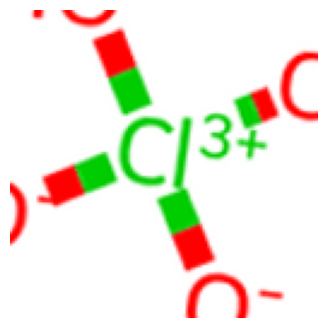

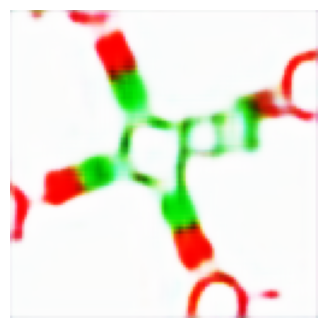

1/1 [==============================] - 1s 847ms/step


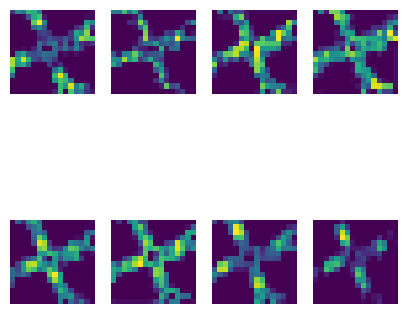

(16, 16, 8)


In [ ]:
# And how encodere works

encoder_model = Model(inputs = input_img, outputs = encoded_)

to_show = 0

image = X_test[to_show]

plt.figure(figsize = (4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

predicted_image = autoencoder_(X_test[:20])
plt.figure(figsize = (4, 4))
plt.imshow(predicted_image[to_show], cmap = 'viridis')
plt.axis('off')
plt.show()

encoded_images = encoder_model.predict(X_test[:20])

num_channels = encoded_images.shape[3]
num_rows = 2
num_columns = num_channels // num_rows

plt.figure(figsize = (5, 5))

for i in range(num_channels):
    ax = plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(encoded_images[to_show, :, :, i], cmap = 'viridis')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

print(encoded_images[1].shape)

(-0.5, 127.5, 127.5, -0.5)

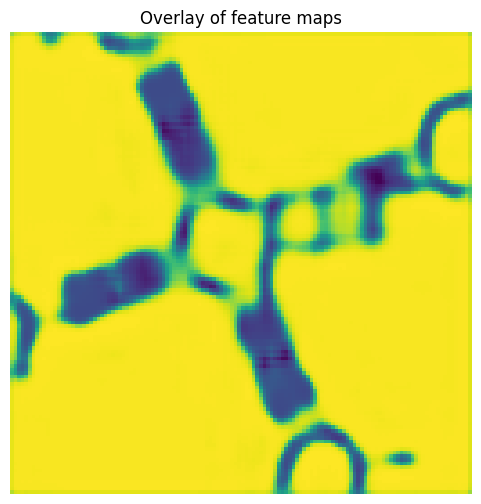

In [ ]:
# And hit maps

overlay = np.sum(predicted_image[to_show], axis = 2)
plt.figure(figsize = (6, 6))
plt.imshow(overlay, cmap = 'viridis')
plt.title("Overlay of feature maps")
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

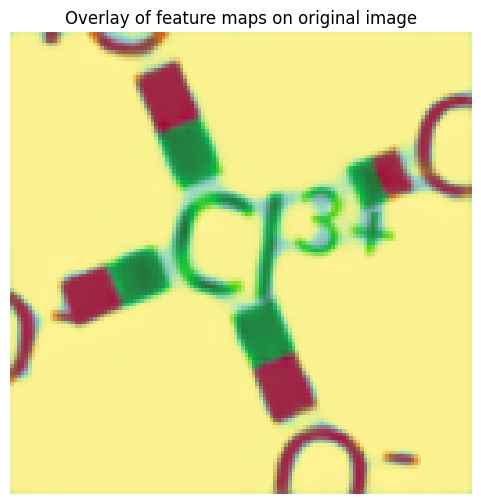

In [ ]:
plt.figure(figsize = (6, 6))
plt.imshow(image, cmap = 'gray')
plt.imshow(overlay, cmap = 'viridis', alpha = 0.5)
plt.title("Overlay of feature maps on original image")
plt.axis('off')